In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm
import time
import pickle

In [104]:
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr=0.2):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)

    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, d, thr):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    df_test=df_test.copy()
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(d))]
    time_unit_data=18000
    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 16*num_ax))
    plt.subplots_adjust(hspace=0.35)
    for i in range(num_ax):
        ax[i].plot(time[i*time_unit_data:time_unit_data*(i+1)], d[i*time_unit_data:time_unit_data*(i+1)], '-r',linewidth = 1, label='異常度')
        ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], label[i*time_unit_data:time_unit_data*(i+1)], facecolor='lime', label='異常ラベル' )

#         #異常と判別したところを強調したい場合
#         ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], z[i*time_unit_data:time_unit_data*(i+1)], facecolor='steelblue' )
        
        ax2=ax[i].twinx()
        ax2.plot(time[i*time_unit_data:time_unit_data*(i+1)], test_plot[i*time_unit_data:time_unit_data*(i+1)], '-k',linewidth = 2, label='騒音レベル')

        ax[i].set_xticks(np.arange(60*i, 60*(i+1),3))
        ax[i].set_xticklabels(np.arange(60*i, 60*(i+1),3), fontsize=40)
        ax[i].xaxis.set_tick_params(rotation=30)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        
        ax[i].set_yticks(np.arange(0, 12, 2)/10)
        ax[i].set_yticklabels(np.arange(0, 12, 2)/10, fontsize=40)
        
        ax2.set_yticks(np.arange(40, 90, 10))
        ax2.set_yticklabels(np.arange(40, 90, 10), fontsize=40)
        
        ax[i].set_ylim(0, 2)
        ax2.set_ylim(10, 80)
        h1, l1 = ax[i].get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax[i].legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':40})
        ax[i].set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=40)
        ax[i].set_ylabel('　　　異常度', fontfamily="MS Mincho",fontsize=40, loc='bottom')
        ax2.set_ylabel('　騒音レベル値(dB)', fontfamily="MS Mincho",fontsize=40, loc='top')
    plt.show()
    return df_test

def figure_detail(df_test, d_test, start=0, stop=60):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_data=int(math.floor(start)*60/0.2)
    stop_data=int(math.ceil(stop)*60/0.2)

    test_plot=df_test['original'].values[start_data:stop_data]
    d=d_test[start_data:stop_data]
    label=df_test['label'].values[start_data:stop_data]*100
    label_index=range(len(label))

    time=[t*0.2/60 for t in range(start_data, stop_data)]
    fig, ax=plt.subplots(1, 1, figsize=(35, 16))

    ax.plot(time, test_plot, '-k',linewidth = 2, label='騒音レベル')
    ax2=ax.twinx()
    ax2.plot(time, d, '-r',linewidth = 2, label='異常度')
    ax.fill_between(time, label, facecolor='lime', label='異常ラベル' )

    ax.set_xticks(np.arange(math.floor(start), math.ceil(stop), 1))
    ax.set_xticklabels(np.arange(math.floor(start), math.ceil(stop), 1), fontsize=50)
#     ax.xaxis.set_tick_params(rotation=30)
    ax.set_xlim(start, stop)

    ax.set_yticks(np.arange(40, 90, 10))
    ax.set_yticklabels(np.arange(40, 90, 10), fontsize=50)        
    ax.set_ylim(40, 80)
    
    ax2.set_yticks(np.arange(0, 12, 2)/10)
    ax2.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=50)

    ax2.set_ylim(0, 2)
    ax.set_ylim(10, 80)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':53})
    ax.set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=53)
    ax.set_ylabel('騒音レベル値(dB)　', fontfamily="MS Mincho",fontsize=53, loc='top')
    ax2.set_ylabel('　　　異常度', fontfamily="MS Mincho",fontsize=53, loc='bottom')
    plt.show()    
    
def fig_pr(test_v, d, bins):
    plt.rcParams["font.size"] = 15
    plt.rcParams["font.family"] = "Times New Roman"
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

#     #F値が最大になる点を明示したい場合
#     plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    #明示しなくていい場合
    plt.plot(recall, precision, '-k',linewidth = 2, label='PR曲線')
    
#     plt.legend(prop={'family':"MS Mincho"}, loc="lower left")
    plt.xlabel('再現率', fontfamily="MS Mincho")
    plt.ylabel('適合率', fontfamily="MS Mincho")
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def auc_gs(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

## ホールドアウト法
### 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
* 訓練（学習用）：0, 1, 2, 3, 4, 5 日目

In [4]:
test_day=[6, 7, 8, 9]
train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
train_df=df[(df['day'].isin(train_day))].reset_index(drop=True)

## 最終評価

In [5]:
best_params={'window': 5, 'nk': 12}

In [28]:
print(f'訓練データ（学習用）：{train_day}日目')
print(f'テストデータ（最終評価用）：{test_day}日目')

window=best_params['window']
df_list=[]
for i in train_day:
    lag=[] 
    lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
    lag.append(train_df.loc[train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
train=pd.concat(df_list)
train=train.dropna().reset_index(drop=True)

df_list=[]

for i in test_day:
    lag=[] 
    lag.append(make_data(test_df.loc[test_df['day']==i, ['original']], 'original', window))
    lag.append(test_df.loc[test_df['day']==i, ['day', 'label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
test=pd.concat(df_list)
test=test.dropna().reset_index(drop=True)

#特徴量とラベルに分割
train_x=train[train.columns[:-1]]
train_y=train[[train.columns[-1]]]

test_x=test[test.columns[:-2]]
test_y=test[[test.columns[-1]]]

#処理時間の計測
time_start=time.perf_counter()

nk=best_params['nk']
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train_x)
d = neigh.kneighbors(test_x)[0]
d = np.mean(d, axis=1)

time_end = time.perf_counter()
process_time=time_end-time_start
print(f'異常度算出にかかる処理時間：{process_time}秒')

test_v=test[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d_test=test_v['d'].values

test_v['time']=[t * 0.2 / 60 for t in range(len(d_test))]

訓練データ（学習用）：[0, 1, 2, 3, 4, 5]日目
テストデータ（最終評価用）：[6, 7, 8, 9]日目
異常度算出にかかる処理時間：106.12419079999995秒


In [8]:
test

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            45.3           45.7           45.8           45.4           45.4   
1            45.3           45.3           45.7           45.8           45.4   
2            45.6           45.3           45.3           45.7           45.8   
3            45.6           45.6           45.3           45.3           45.7   
4            45.5           45.6           45.6           45.3           45.3   
...           ...            ...            ...            ...            ...   
1601919      45.9           45.6           45.4           45.9           46.0   
1601920      45.6           45.9           45.6           45.4           45.9   
1601921      45.8           45.6           45.9           45.6           45.4   
1601922      45.7           45.8           45.6           45.9           45.6   
1601923      45.9           45.7           45.8           45.6           45.9   

         day  label  
0          6      0  
1          6      0  
2          6      0  
3          6      0  
4          6      0  
...      ...    ...  
1601919    9      0  
1601920    9      0  
1601921    9      0  
1601922    9      0  
1601923    9      0  

[1601924 rows x 7 columns]

In [21]:
test.iloc[test.loc[test['day']==7].index, :]

original  original_lag1  original_lag2  original_lag3  original_lag4  \
359981      48.0           48.0           47.8           48.2           47.6   
359982      48.7           48.0           48.0           47.8           48.2   
359983      49.6           48.7           48.0           48.0           47.8   
359984      49.8           49.6           48.7           48.0           48.0   
359985      50.1           49.8           49.6           48.7           48.0   
...          ...            ...            ...            ...            ...   
773957      46.4           46.1           46.1           46.4           46.8   
773958      45.8           46.4           46.1           46.1           46.4   
773959      46.1           45.8           46.4           46.1           46.1   
773960      45.8           46.1           45.8           46.4           46.1   
773961      45.8           45.8           46.1           45.8           46.4   

        day  label  
359981    7      0  
359982    7      0  
359983    7      0  
359984    7      0  
359985    7      0  
...     ...    ...  
773957    7      1  
773958    7      1  
773959    7      1  
773960    7      1  
773961    7      1  

[413981 rows x 7 columns]

## PR曲線

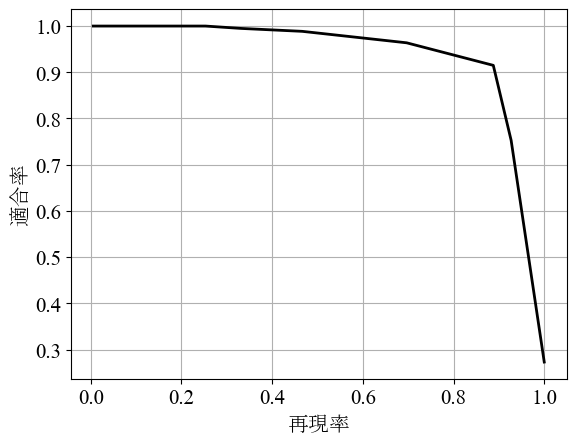

AUC：0.9338602580484126
理想の閾値：0.08
F値（最高）：0.9010841924776769
適合率（最高）：0.9149414219226448
再現率（最高）：0.8876404494382022


In [16]:
thr_bins=20
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 異常度可視化

In [22]:
p, r=validate(test_v, d_test, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

適合率：0.9149414219226448
再現率：0.8876404494382022


In [23]:
test_day

[6, 7, 8, 9]

In [109]:
check_day=7
check_test_v=test_v.iloc[test.loc[test['day']==check_day].index, :]
check_d_test=check_test_v['d'].values

In [110]:
thr=0.08
check_test_v=figure(check_test_v, check_d_test, thr)

## 異常度グラフズーム

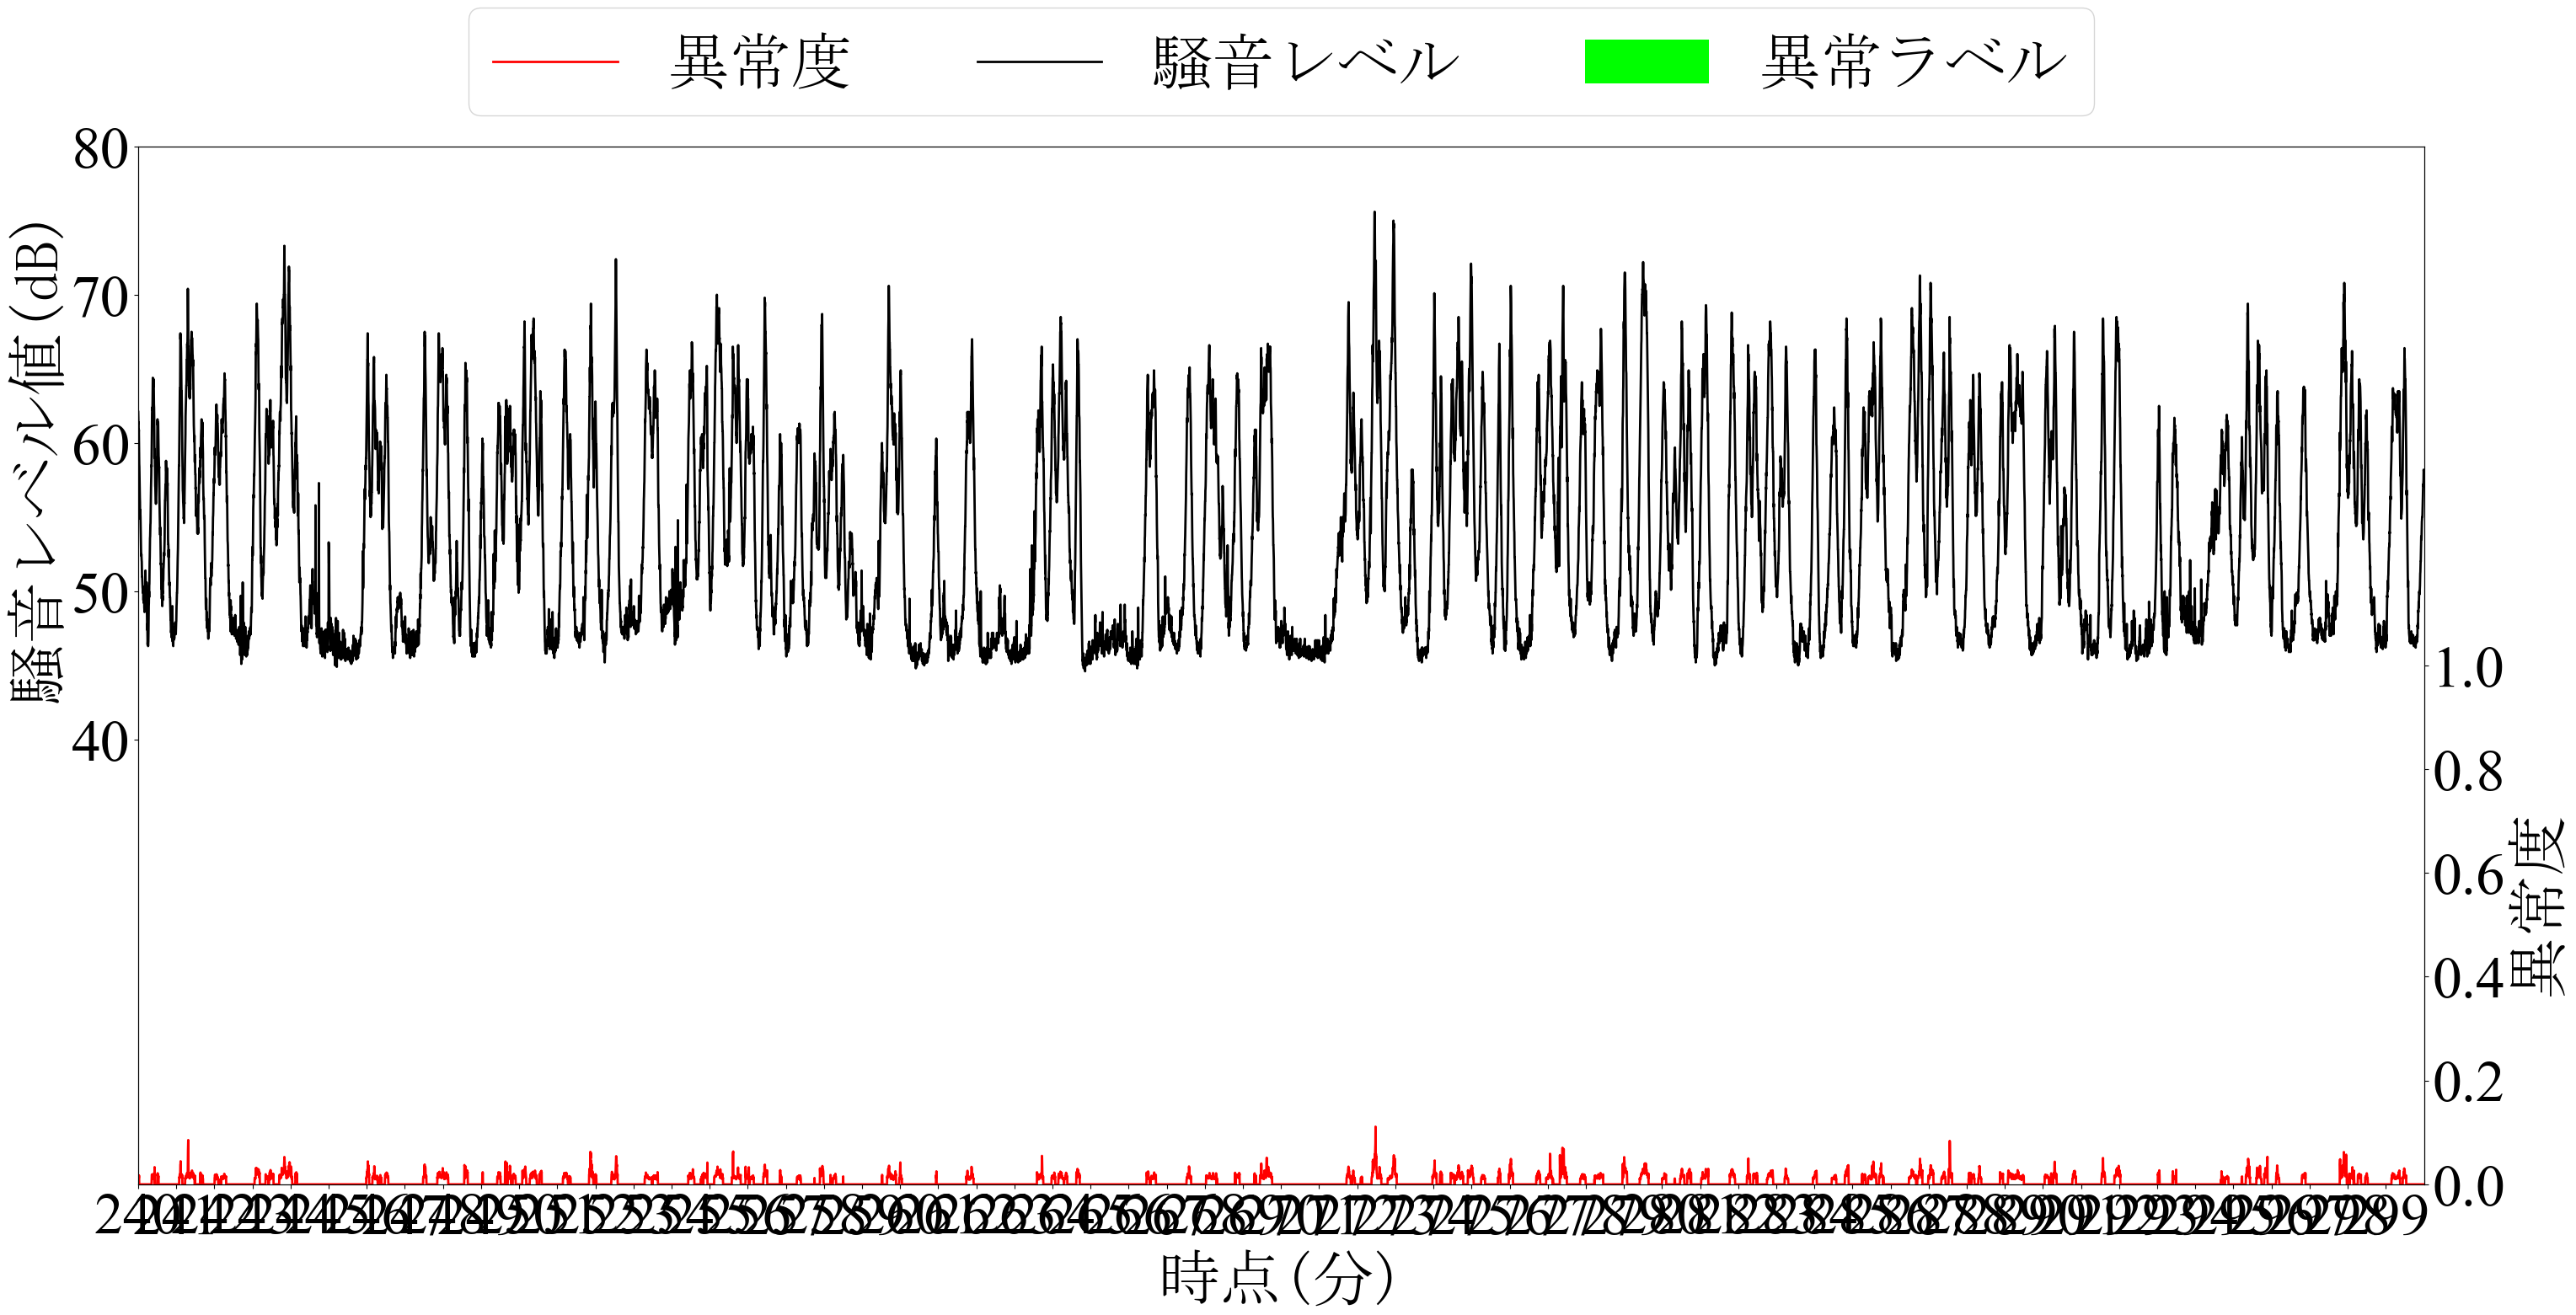

In [11]:
start=240
stop=300
figure_detail(test_v, d_test, start, stop)

## 異常度のヒストグラム

(array([3.19150e+04, 1.61919e+05, 5.46890e+04, 1.61260e+04, 7.36700e+03,
        4.02700e+03, 2.59900e+03, 1.80500e+03, 1.37000e+03, 1.13200e+03,
        8.55000e+02, 7.21000e+02, 5.02000e+02, 4.35000e+02, 3.58000e+02,
        3.11000e+02, 2.16000e+02, 1.91000e+02, 1.43000e+02, 1.41000e+02,
        9.80000e+01, 9.40000e+01, 7.20000e+01, 4.90000e+01, 4.60000e+01,
        4.40000e+01, 3.50000e+01, 3.00000e+01, 2.00000e+01, 2.20000e+01,
        2.30000e+01, 1.70000e+01, 1.30000e+01, 9.00000e+00, 4.00000e+00,
        8.00000e+00, 1.10000e+01, 5.00000e+00, 5.00000e+00, 3.00000e+00,
        9.00000e+00, 9.00000e+00, 5.00000e+00, 2.00000e+00, 3.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00,
        3.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

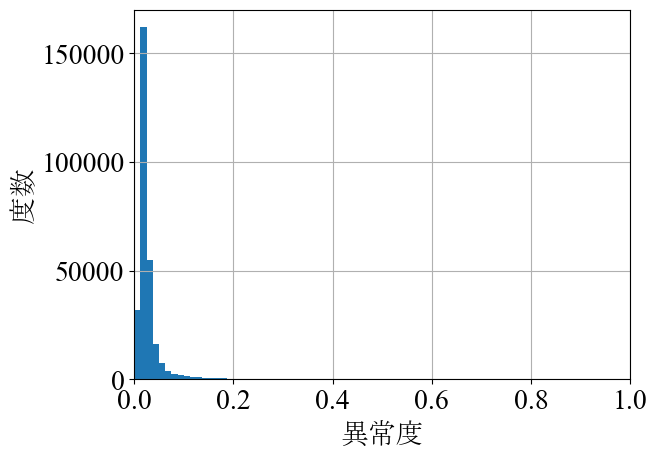

In [17]:
d_hist=d/d.max()

plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)
plt.xlabel("異常度", fontfamily="MS Mincho",fontsize=20)            
plt.ylabel("度数", fontfamily="MS Mincho",fontsize=20)  
plt.xlim(0, 1)
plt.hist(d_hist, bins=80)

## 箱ひげ外れ値検知のパラメータチューニング

In [ ]:
print(f'訓練データ（学習用）：{train_day}日目')
print(f'検証データ（チューニング用）：{valid_day}日目')

ratio_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_score=0

window=best_params['window']
df_list=[]
for i in train_day:
    lag=[] 
    lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
    lag.append(train_df.loc[train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
train=pd.concat(df_list)
train=train.dropna().reset_index(drop=True)

df_list=[]
for i in valid_day:
    lag=[] 
    lag.append(make_data(valid_df.loc[valid_df['day']==i, ['original']], 'original', window))
    lag.append(valid_df.loc[valid_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
valid=pd.concat(df_list)
valid=valid.dropna().reset_index(drop=True)

#特徴量とラベルに分割
train_x=train[train.columns[:-1]]
train_y=train[[train.columns[-1]]]

valid_x=valid[valid.columns[:-1]]
valid_y=valid[[valid.columns[-1]]]

nk=best_params['nk']
neigh = NearestNeighbors(n_neighbors=nk)
neigh.fit(train_x)
d = neigh.kneighbors(valid_x)[0]
d = np.mean(d, axis=1)

test_v=valid[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d_test=test_v['d'].values

#kmeans
n_clusters=2
model = KMeans(n_clusters=n_clusters)  
model.fit(d_test.reshape((-1, 1)))
clusters = model.predict(d_test.reshape((-1, 1)))  
result=pd.DataFrame({'d':d_test, 'cluster':clusters})
thr_list=[]
for j in range(n_clusters):
    thr_list.append(result.loc[result['cluster']==j, 'd'].max())
thr_min=sorted(thr_list)[-2]
thr_max=sorted(thr_list)[-1]

thr_range=result.loc[(result['d']>thr_min)&(result['d']<=thr_max), ['d']]
Q1 = thr_range.quantile(0.25)
Q3 = thr_range.quantile(0.75)
IQR = Q3 - Q1

for r in ratio_list:
    thr = min(float(Q3 + r * IQR), thr_max)
    
    #f値計算
    precision, recall=validate(test_v, d_test, thr)
    f_score=(2*precision*recall)/(precision+recall)
    if f_score>best_score:
        best_score=f_score
        best_params['box_ratio']=r
        print(f'更新F値：{best_score}')
                    
print('==================================================================')
print(f'F値最高：{best_score}')
print(f'パラメータ：{best_params}')

### チューニング結果
* パラメータ：{'window': 5, 'nk': 23, 'box_ratio': 0.1}